To a first approximation, the composite frequency spectrum provided by a LIBS gun is a weighted superposition of the single element spectra. The base assumption is that the weighting is proportional to their abundance in the sample. This notebook applies a straightforward least squares minimization to decompose a composite spectrum into the atomic composition.

Artifacts and noise can be added to the composite spectrum to explore the impact on fit vs. the "clean" spectrum. Various pre-processing steps could also be explored prior to the fit to see what types of noise filtering/cleaning might be effective.

The simplistic approach can serve as a benchmark for more complex approaches to spectral decomposition.

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

import pickle
import datetime
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.optimize import least_squares
from libs_unet.models import peakyfinder_0001
from libs_unet.training.spec_maker import spectrum_maker

top_dir = Path.cwd()
datapath = top_dir / 'data'
#Update these as model evolves
meta_path = datapath / 'training' / 'el80_pairs_meta.pickle'
param_path = top_dir / 'trained_models' / 'el80_pairs_lg_0001'
nist_mult = 1.17
sciap_mult = 0.0689 
fit_tol = 0.01

In [31]:
#Reference data, used but not changed within classes
with open(meta_path, 'rb') as f:
    wave = pickle.load(f)
    el_symbol = pickle.load(f)
    el_index = pickle.load(f)

max_z = len(el_symbol)
model = peakyfinder_0001.LIBSUNet(max_z,len(wave))
model.load_state_dict(torch.load(param_path))


#Generate atomic reference spectra
spec_maker = spectrum_maker()
el_spec = np.zeros((max_z,len(wave)))
for i in range(max_z):
    fracs_dict = {el_symbol[i]:1}
    wave, spec_dict, lines_dict = spec_maker.make_spectra(fracs_dict)
    el_spec[i] = spec_dict['comp']
#Apply nist data multiplier to scale spectral intensities
#Could probably drop this and remove upper limit on weights. Weights are rescaled to sum=1
el_spec = nist_mult * el_spec

<function matplotlib.pyplot.show(close=None, block=None)>

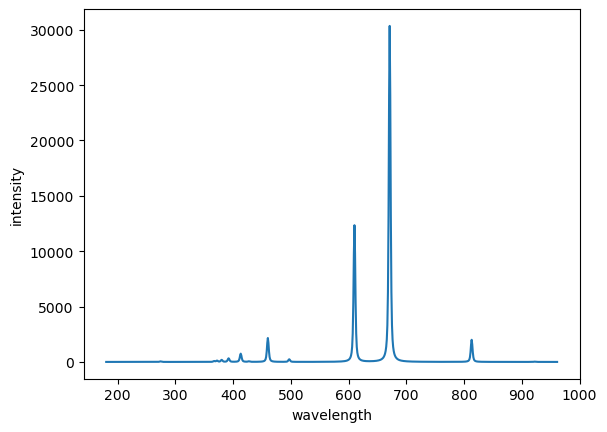

In [33]:
#check spectra
el = 'Li'
plt.plot(wave, el_spec[el_index[el]])
plt.xlabel('wavelength')
plt.ylabel('intensity')
plt.show #makes sense 671 ~ 30,000 which is ~3x reference 10,000 in Li2CO3

In [34]:
#next task is to find the linear combination of the atomic spectra that minimizes error to input spectrum
#Try https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

#define the residuals function (note algorithm squares for SSE)
#TODO rather than weighting atomic spec, better residual from creating new composite spec from weighted lines
def fun_fitspec(x, x_spec, ref_specs):
    return np.squeeze(np.sum((ref_specs.transpose() * x).transpose(), axis=0) - x_spec)

#weight bounds passed as a 2-tuple of vectors ([lower], [upper]) use np.inf for unbounded
#lower bound for all is non-negative weights
bnd_low = np.zeros(max_z)
#upper bound is 1 (pure). must include small delta to zero to exclude, e.g. 0.0001
bnd_up = np.ones(max_z)
el_bounds = (bnd_low, bnd_up)
#Initial guess at weights is even allocation
x0 = np.ones(max_z) * (1/max_z)
#use the following form to run the LS min for a given input_spec of shape 
#el_fit = least_squares(fun_fitspec, x0, args=(input_spec, el_spec), bounds=el_bounds)

In [35]:
#Test LiCO3
test_dict = {'Li':2, 'C':1, 'O':3}
#generate input spectrum
wave, spec_dict, spec_dict = spec_maker.make_spectra(test_dict)
test_spec = nist_mult * spec_dict['comp']
test_fit = least_squares(fun_fitspec, x0, args=(test_spec, el_spec), bounds=el_bounds)

In [40]:
#review results. Note bounds would be adjusted based on any classification prior info
#library does not allow linear constraints so cannot constrain sum of x <=1
fit_wts = test_fit.x.copy()
fit_wts[fit_wts < 0.01] = 0
fit_wts = fit_wts / np.sum(fit_wts)

for i in range(len(fit_wts)):
    if fit_wts[i] > 0 or el_symbol[i] in test_dict:
        input_wt = 0
        if el_symbol[i] in test_dict:
            input_wt = test_dict[el_symbol[i]]
        print(f"{el_symbol[i]}: ref: {np.round(input_wt,3)} pred: {np.round(fit_wts[i],3)}")


Li: ref: 0.333 pred: 0.371
C: ref: 0.167 pred: 0.186
O: ref: 0.5 pred: 0.443


In [37]:
#Apply L-S fit to experimental Li2CO3 spectrum
libs_spec = np.genfromtxt(datapath / "experimental/LIBS_Li2CO3.csv", delimiter=',', skip_header=1)
#resample to our model specs for wavelength resolution
libs_wave = libs_spec[:,0]
libs_intens = libs_spec[:,1]
#Convert input data to model format if needed
wave_dict = {wl:0 for wl in wave}
for i in range(len(libs_wave)):
    int_wl = np.round(libs_wave[i],0)
    if int_wl in wave_dict:
        wave_dict[int_wl] += libs_intens[i]
x_spec = np.array([])
for wl, intens in wave_dict.items():
    x_spec = np.append(x_spec, intens)
#apply scaling factor
x_spec = sciap_mult * x_spec

<function matplotlib.pyplot.show(close=None, block=None)>

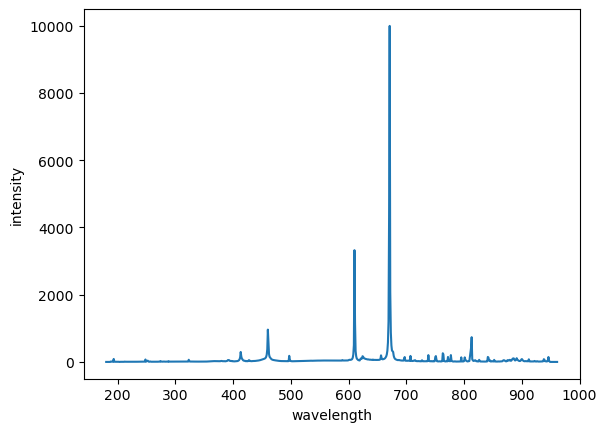

In [39]:
#Review experimental Li2CO3 spectrum plot
plt.plot(wave, x_spec)
plt.xlabel('wavelength')
plt.ylabel('intensity')
plt.show # Looks properly scaled

In [44]:
#Obtain element weights from least squares fit to experimental input spectrum

#obtain fit object
test_fit = least_squares(fun_fitspec, x0, args=(x_spec, el_spec), bounds=el_bounds)
#weights below tolerance discarded and total weights rescaled to 1
fit_wts = test_fit.x.copy()
fit_wts[fit_wts < fit_tol] = 0
print("raw fit weights")
for i in range(len(fit_wts)):
    if fit_wts[i] > 0:
        print(f"{el_symbol[i]}: {np.round(fit_wts[i],4)}")
#scale to sum 1
fit_wts = fit_wts / np.sum(fit_wts)
print("scaled element weights")
for i in range(len(fit_wts)):
    if fit_wts[i] > 0:
        print(f"{el_symbol[i]}: {np.round(fit_wts[i],4)}")

raw fit weights
H: 0.1749
Li: 0.1886
N: 0.2002
O: 0.1791
F: 1.0
Ar: 1.0
Br: 0.0566
Xe: 0.0287
Ta: 0.1096
scaled element weights
H: 0.0595
Li: 0.0642
N: 0.0681
O: 0.061
F: 0.3404
Ar: 0.3404
Br: 0.0193
Xe: 0.0098
Ta: 0.0373
